<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/MB99_checkEpochs_snirf0_with_Entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install & import `nilearn` and `mne-nirs`

In [ ]:
#@markdown
!pip install nilearn
!pip install -U --no-deps https://github.com/mne-tools/mne-python/archive/main.zip
!pip install mne-nirs

from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne 



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 23.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 61.5 MB 153 kB/s
  Created wheel for mne: filename=mne-1.1.dev0-py3-none-any.whl size=7434596 sha256=464c912d7ea3da6035fccc37f1b40aa10d9643f53f2d8cdd91c39e87a10a2270
  Stored in directory: /tmp/pip-ephem-wheel-cache-iztnkeal/wheels/66/fc/d2/9d32190e71b47

## Mount Google Drive

In [ ]:
#@markdown
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Common Imports

In [ ]:
#@markdown 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import h5py
from itertools import compress
from sklearn.preprocessing import scale
from google.colab import widgets

In [ ]:
path = '/content/drive/MyDrive/cond 1/snirf/snirf0/'

df_epochs_all = pd.read_excel( path + '13_run1_epochs.xlsx')
df_epochs_all.head()

,time,condition,epoch,S1_D1 hbo,S1_D1 hbr,S1_D8 hbo,S1_D8 hbr,S1_D14 hbo,S1_D14 hbr,S2_D2 hbo,...,S5_D14 hbo,S5_D14 hbr,S5_D15 hbo,S5_D15 hbr,S6_D10 hbo,S6_D10 hbr,S6_D12 hbo,S6_D12 hbr,S6_D13 hbo,S6_D13 hbr
0,-5000,Sync1,0,0,0,0,0,23.024617,-1.596118,-5.929954,...,-8.278716,-6.791902,-11.194100,-8.175648,0,0,-2.690123,0.073800,0,0
1,-4900,Sync1,0,0,0,0,0,28.160595,-2.176457,-6.027119,...,-6.720704,-6.026266,-10.047608,-7.546052,0,0,-2.453076,0.121582,0,0
2,-4800,Sync1,0,0,0,0,0,30.051818,-2.438888,-5.450200,...,-5.125164,-5.218035,-8.671589,-6.801530,0,0,-2.176323,0.132601,0,0
3,-4700,Sync1,0,0,0,0,0,28.018809,-2.286079,-4.321715,...,-3.553986,-4.397760,-7.119993,-5.966014,0,0,-1.857001,0.106632,0,0
4,-4600,Sync1,0,0,0,0,0,22.242439,-1.715520,-2.793562,...,-2.070517,-3.599954,-5.482181,-5.080049,0,0,-1.502927,0.049445,0,0


In [ ]:
import pickle

infile = open('/content/drive/MyDrive/cond 1/snirf/selected_sub_channels.pickle','rb')
selected_sub_channels = pickle.load(infile)
infile.close()

selected_sub_channels.keys()

dict_keys(['selected_sub', 'good_list', 'bad_list', 'channel_SD_selected'])

In [ ]:
selected_sub_channels['selected_sub']

['17_run1',
 '36_run1',
 '33_run1',
 '13_run1',
 '14_run1',
 '34_run1',
 '29_run1',
 '38_run1',
 '5_run1',
 '31_run1',
 '25_run1']

In [ ]:
#
# take care... if done before MB03 was corrected to create channel_SD_selected! ...if not ok use next block
#
channel_SD_selected = selected_sub_channels['channel_SD_selected']
channel_SD_selected

,channel_name,channel_type,channel_hole
0,S1_D1,Motor,Hole1(D1-B2)
1,S1_D8,Motor,Hole9(D8-B2)
4,S2_D3,Motor,Hole3(B2-D3)
5,S2_D8,Motor,Hole9(D8-D2)
6,S2_D9,Motor,Hole13(D1-B3)
7,S2_D11,Parietal,Hole16(D3-B3)
8,S3_D4,Parietal,Hole4(D4-B2)
9,S3_D5,Parietal,Hole5(D5-B2)
11,S3_D10,Parietal,Hole14(D2-B3)
12,S3_D12,Parietal,Hole17(D4-B3)


In [ ]:
channel_SD = pd.read_csv('https://github.com/Rogerio-mack/fNIRS/raw/main/channel_types.csv')
display( channel_SD.head() )

good_list = selected_sub_channels['good_list']
print(good_list)

good_set = set( [x.split(' ')[0] for x in good_list] )
channel_SD_selected = channel_SD[ channel_SD.channel_name.isin(good_set) ]
channel_SD_selected

,channel_name,channel_type,channel_hole
0,S1_D1,Motor,Hole1(D1-B2)
1,S1_D8,Motor,Hole9(D8-B2)
2,S1_D14,Motor,Hole20(D6-B3)
3,S2_D2,Motor,Hole2(B2-D2)
4,S2_D3,Motor,Hole3(B2-D3)


['S1_D14 685', 'S1_D14 830', 'S2_D2 685', 'S2_D2 830', 'S3_D9 685', 'S3_D9 830', 'S4_D10 685', 'S4_D10 830', 'S4_D13 685', 'S4_D13 830', 'S4_D6 685', 'S4_D6 830', 'S5_D11 685', 'S5_D11 830', 'S5_D14 685', 'S5_D14 830', 'S5_D15 685', 'S5_D15 830', 'S5_D8 685', 'S5_D8 830', 'S6_D12 685', 'S6_D12 830']


,channel_name,channel_type,channel_hole
2,S1_D14,Motor,Hole20(D6-B3)
3,S2_D2,Motor,Hole2(B2-D2)
10,S3_D9,Motor,hole13(D1-B3)
13,S4_D6,Parietal,Hole6(|D6-B2)
15,S4_D10,Parietal,Hole14(D2-B3)
16,S4_D13,Parietal,Hole19(D5-B3)
17,S5_D8,Motor,Hole9(D8-B1)
18,S5_D11,Parietal,Hole16(D3-B3)
19,S5_D14,Motor,Hole20(D6-B3)
20,S5_D15,Motor,Hole21(D7-B3)


In [ ]:
Motor_channels = channel_SD_selected[channel_SD_selected.channel_type == 'Motor']['channel_name'].tolist()
Parietal_channels = channel_SD_selected[channel_SD_selected.channel_type == 'Parietal']['channel_name'].to_list()
print(Motor_channels)
print(Parietal_channels)

['S1_D14', 'S2_D2', 'S3_D9', 'S5_D8', 'S5_D14', 'S5_D15']
['S4_D6', 'S4_D10', 'S4_D13', 'S5_D11', 'S6_D12']


In [ ]:
HBO_Motor_channels = [ x for x in df_epochs_all.columns if 'hbo' in x and x.split(' ')[0] in Motor_channels ]
print(HBO_Motor_channels)

HBR_Motor_channels = [ x for x in df_epochs_all.columns if 'hbr' in x and x.split(' ')[0] in Motor_channels ]
print(HBR_Motor_channels)

HBO_Parietal_channels = [ x for x in df_epochs_all.columns if 'hbo' in x and x.split(' ')[0] in Parietal_channels ]
print(HBO_Parietal_channels)

HBR_Parietal_channels = [ x for x in df_epochs_all.columns if 'hbr' in x and x.split(' ')[0] in Parietal_channels ]
print(HBR_Parietal_channels)

['S1_D14 hbo', 'S2_D2 hbo', 'S3_D9 hbo', 'S5_D8 hbo', 'S5_D14 hbo', 'S5_D15 hbo']
['S1_D14 hbr', 'S2_D2 hbr', 'S3_D9 hbr', 'S5_D8 hbr', 'S5_D14 hbr', 'S5_D15 hbr']
['S4_D6 hbo', 'S4_D10 hbo', 'S4_D13 hbo', 'S5_D11 hbo', 'S6_D12 hbo']
['S4_D6 hbr', 'S4_D10 hbr', 'S4_D13 hbr', 'S5_D11 hbr', 'S6_D12 hbr']


In [ ]:
df_epochs_mean = df_epochs_all[['time', 'condition', 'epoch']].copy()

HBO_Motor, HBR_Motor, HBO_Parietal, HBR_Parietal = [], [], [], []
for _, row in df_epochs_all.iterrows():
  HBO_Motor.append( row[ HBO_Motor_channels ].mean() )
  HBR_Motor.append( row[ HBR_Motor_channels ].mean() )
  HBO_Parietal.append( row[ HBO_Parietal_channels ].mean() )
  HBR_Parietal.append( row[ HBR_Parietal_channels ].mean() )

df_epochs_mean['HBO_Motor'] = HBO_Motor
df_epochs_mean['HBR_Motor'] = HBR_Motor
df_epochs_mean['HBO_Parietal'] = HBO_Parietal
df_epochs_mean['HBR_Parietal'] = HBR_Parietal

df_epochs_mean.head()

,time,condition,epoch,HBO_Motor,HBR_Motor,HBO_Parietal,HBR_Parietal
0,-5000,Sync1,0,-0.485504,-0.315853,-1.002328,-0.105796
1,-4900,Sync1,0,0.936148,-0.216806,-0.717185,-0.098239
2,-4800,Sync1,0,1.983157,-0.194516,-0.406268,-0.101165
3,-4700,Sync1,0,2.497868,-0.215402,-0.067417,-0.109886
4,-4600,Sync1,0,2.453413,-0.254171,0.290372,-0.121426


In [ ]:
df_epochs_mean['condition_phase'] = df_epochs_mean['condition'].apply(lambda x: x[-1])

In [ ]:
df_epochs_mean['condition_type'] = df_epochs_mean['condition'].apply(lambda x: x[0:-1])

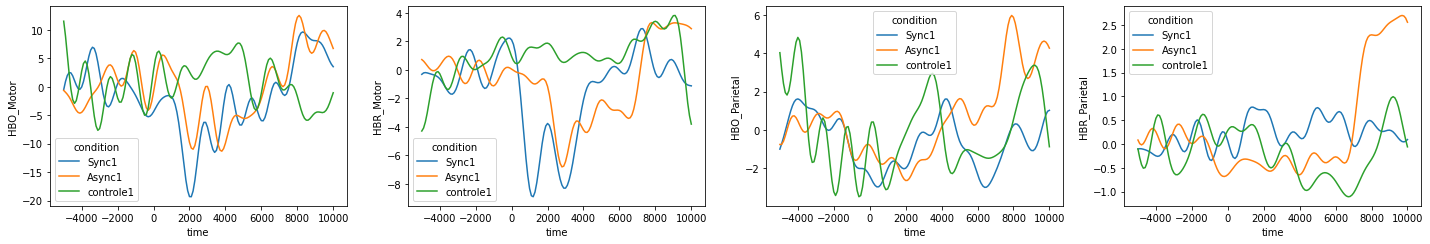

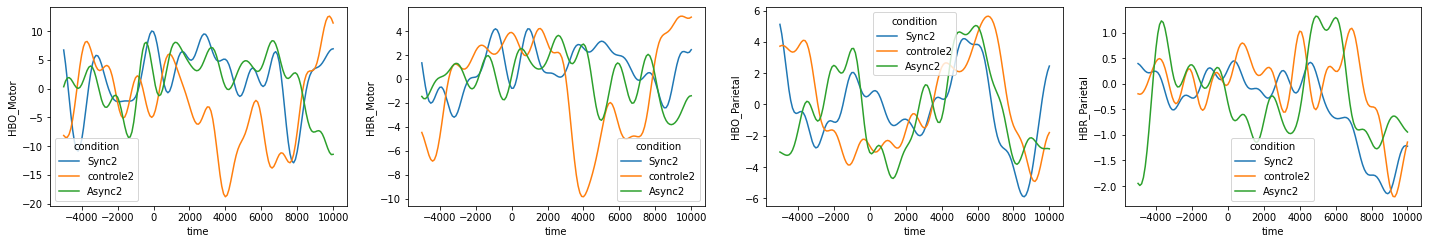

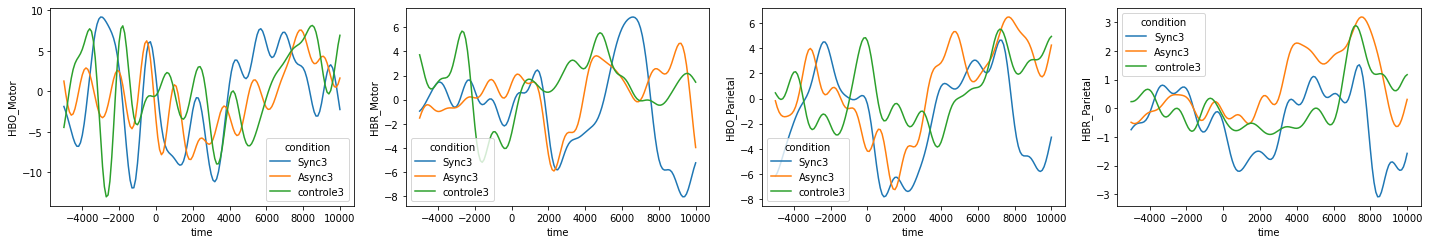

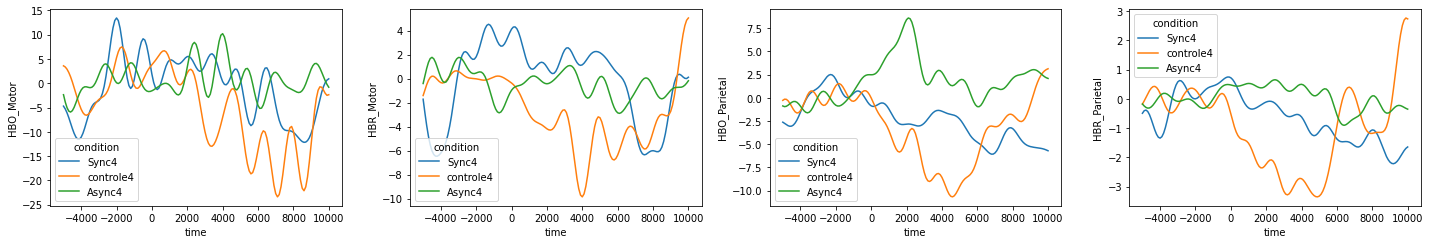

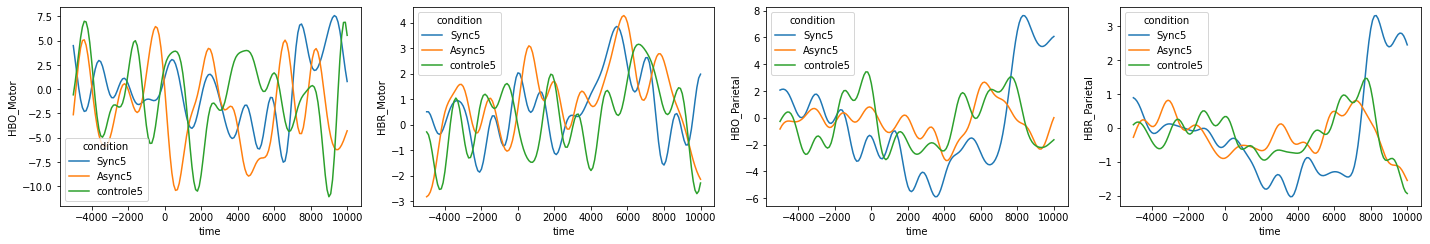

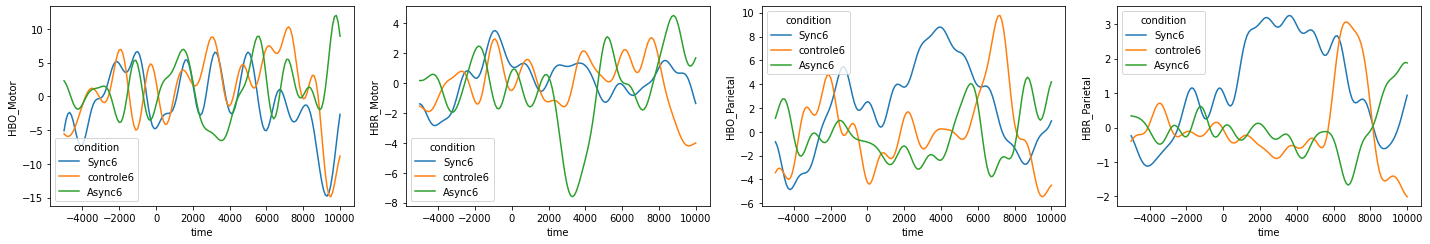

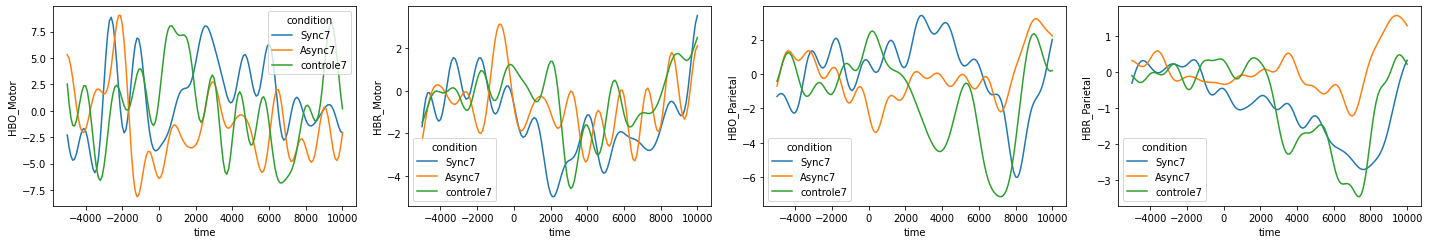

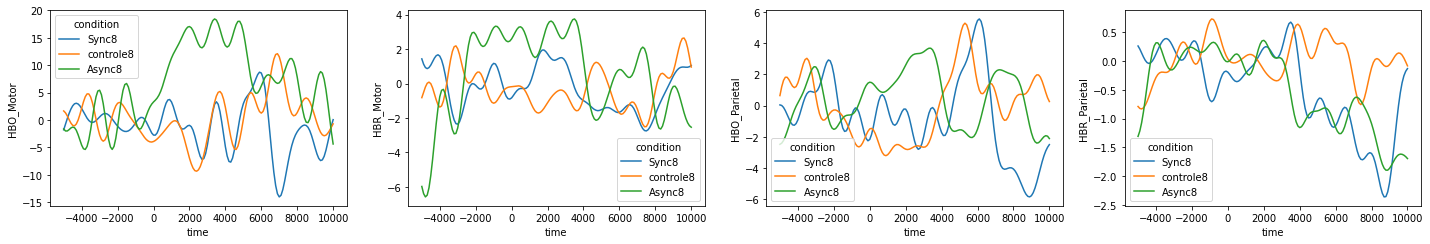

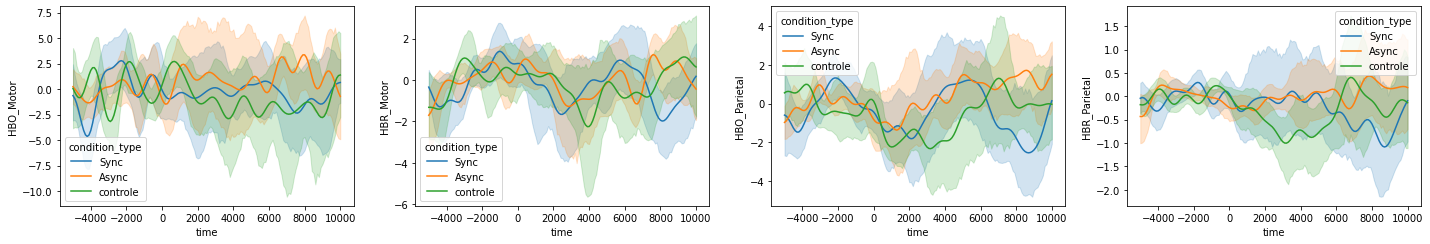

In [ ]:
for i in range(1,9):
  fig = plt.figure(figsize=(20,3.5))
  plt.subplot(1,4,1)
  sns.lineplot(x='time', y='HBO_Motor', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,2)
  sns.lineplot(x='time', y='HBR_Motor', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,3)
  sns.lineplot(x='time', y='HBO_Parietal', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,4)
  sns.lineplot(x='time', y='HBR_Parietal', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])

  plt.tight_layout()
  plt.show()

fig = plt.figure(figsize=(20,3.5))
plt.subplot(1,4,1)
sns.lineplot(x='time', y='HBO_Motor', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,2)
sns.lineplot(x='time', y='HBR_Motor', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,3)
sns.lineplot(x='time', y='HBO_Parietal', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,4)
sns.lineplot(x='time', y='HBR_Parietal', hue='condition_type', data=df_epochs_mean )

plt.tight_layout()
plt.show()

In [ ]:
entries = []
for f in os.listdir('/content/drive/MyDrive/cond 1/snirf/snirf0'):
  if '_epochs.xlsx' in f:
    entries.append(f)

entries

['17_run1_epochs.xlsx',
 '36_run1_epochs.xlsx',
 '33_run1_epochs.xlsx',
 '13_run1_epochs.xlsx',
 '14_run1_epochs.xlsx',
 '34_run1_epochs.xlsx',
 '29_run1_epochs.xlsx',
 '38_run1_epochs.xlsx',
 '5_run1_epochs.xlsx',
 '31_run1_epochs.xlsx',
 '25_run1_epochs.xlsx']

In [ ]:
df_epochs_all.shape

(3624, 51)

In [ ]:
df_epochs_total = pd.DataFrame()

for f in entries:
  df =  pd.read_excel( path + f )
  df_epochs_total = pd.concat([ df_epochs_total , df])

df_epochs_total.shape

(39864, 51)

In [ ]:
df_epochs_mean = df_epochs_total[['time', 'condition', 'epoch']].copy()

HBO_Motor, HBR_Motor, HBO_Parietal, HBR_Parietal = [], [], [], []
for _, row in df_epochs_total.iterrows():
  HBO_Motor.append( row[ HBO_Motor_channels ].mean() )
  HBR_Motor.append( row[ HBR_Motor_channels ].mean() )
  HBO_Parietal.append( row[ HBO_Parietal_channels ].mean() )
  HBR_Parietal.append( row[ HBR_Parietal_channels ].mean() )

df_epochs_mean['HBO_Motor'] = HBO_Motor
df_epochs_mean['HBR_Motor'] = HBR_Motor
df_epochs_mean['HBO_Parietal'] = HBO_Parietal
df_epochs_mean['HBR_Parietal'] = HBR_Parietal

df_epochs_mean.head()

,time,condition,epoch,HBO_Motor,HBR_Motor,HBO_Parietal,HBR_Parietal
0,-5000,Sync1,0,-5.673266,-3.091258,-5.953643,-1.455818
1,-4900,Sync1,0,-5.543343,-3.266478,-5.602053,-1.195737
2,-4800,Sync1,0,-5.586097,-3.088467,-5.226868,-0.979622
3,-4700,Sync1,0,-5.665532,-2.654327,-4.816863,-0.818806
4,-4600,Sync1,0,-5.648439,-2.096761,-4.363594,-0.717332


In [ ]:
df_epochs_mean['condition_phase'] = df_epochs_mean['condition'].apply(lambda x: x[-1])

In [ ]:
df_epochs_mean['condition_type'] = df_epochs_mean['condition'].apply(lambda x: x[0:-1])

In [ ]:
df_epochs_mean = df_epochs_mean.reset_index(drop=True)
df_epochs_mean.head()

,time,condition,epoch,HBO_Motor,HBR_Motor,HBO_Parietal,HBR_Parietal,condition_phase,condition_type
0,-5000,Sync1,0,-5.673266,-3.091258,-5.953643,-1.455818,1,Sync
1,-4900,Sync1,0,-5.543343,-3.266478,-5.602053,-1.195737,1,Sync
2,-4800,Sync1,0,-5.586097,-3.088467,-5.226868,-0.979622,1,Sync
3,-4700,Sync1,0,-5.665532,-2.654327,-4.816863,-0.818806,1,Sync
4,-4600,Sync1,0,-5.648439,-2.096761,-4.363594,-0.717332,1,Sync


In [ ]:
def SampEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

epochs_entropy = {}
for event in df_epochs_mean.condition.unique():
  epochs_entropy[event] = {}
  for HB in ['HBO_Motor','HBR_Motor','HBO_Parietal','HBR_Parietal']:
    s_values = np.array( df_epochs_mean[df_epochs_mean.condition == event][HB] )
    epochs_entropy[event][HB] = [ SampEn(s_values, m=2, r=0.2*np.std(s_values)) ]
    print(event, ' ', HB, ' Entropy: ', SampEn(s_values, m=2, r=0.2*np.std(s_values)))

Sync1   HBO_Motor  Entropy:  0.5562956718710956
Sync1   HBR_Motor  Entropy:  0.49088991685113603
Sync1   HBO_Parietal  Entropy:  0.15722758357228495
Sync1   HBR_Parietal  Entropy:  0.36396282285895554
Async1   HBO_Motor  Entropy:  0.600539036368549
Async1   HBR_Motor  Entropy:  0.573227461106713
Async1   HBO_Parietal  Entropy:  0.41066617677455053
Async1   HBR_Parietal  Entropy:  0.4484476187067714
controle1   HBO_Motor  Entropy:  0.623096422953866
controle1   HBR_Motor  Entropy:  0.5473526777876376
controle1   HBO_Parietal  Entropy:  0.41235787746885766
controle1   HBR_Parietal  Entropy:  0.43499181202150616
Sync2   HBO_Motor  Entropy:  0.5820636335179676
Sync2   HBR_Motor  Entropy:  0.5019646329269971
Sync2   HBO_Parietal  Entropy:  0.4131160797765774
Sync2   HBR_Parietal  Entropy:  0.41681773042310644
controle2   HBO_Motor  Entropy:  0.5757282093440073
controle2   HBR_Motor  Entropy:  0.5423471049354855
controle2   HBO_Parietal  Entropy:  0.4355790889022333
controle2   HBR_Parietal 

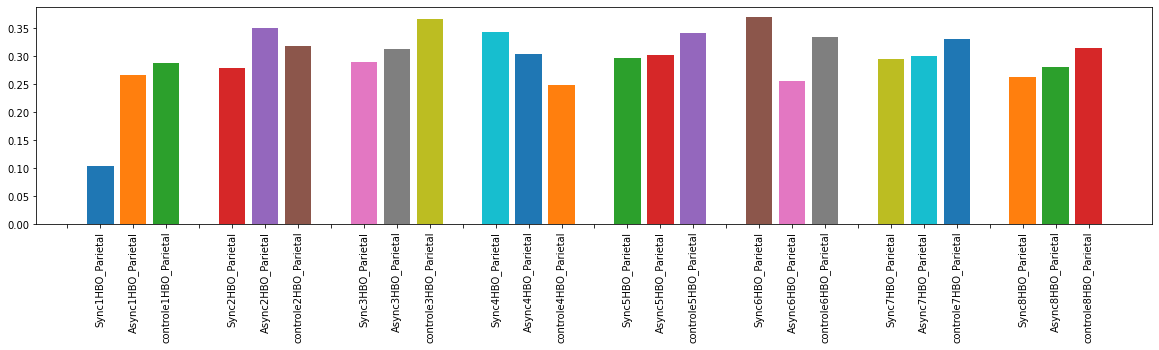

In [ ]:
plt.figure(figsize=(20,4))
i = 0
ticks = []

for k in range(1,9):
  i = i + 1
  ticks.append(' ')
  for event_type in ['Sync','Async','controle']:
    for HB in ['HBO_Motor']: # ,'HBR_Motor','HBO_Parietal','HBR_Parietal']: 
      event = event_type + str(k)
      plt.bar(i, epochs_entropy[event][HB][0])
      ticks.append(event + HB)
      i = i + 1

plt.xticks(np.arange(i),labels=ticks,rotation=90)
plt.show()

In [ ]:
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))



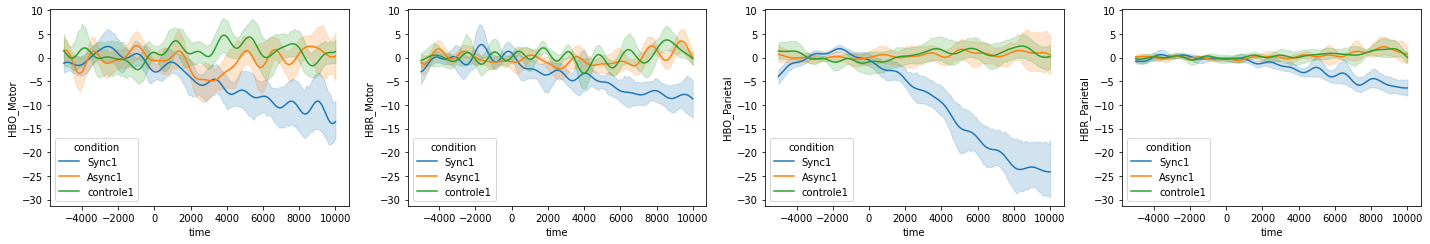

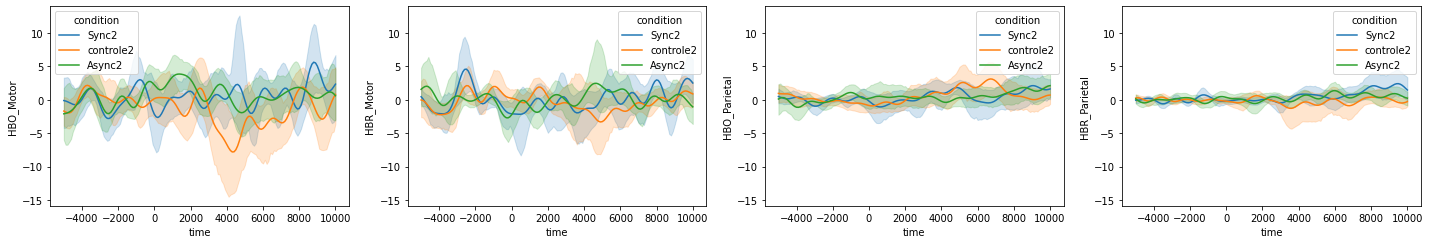

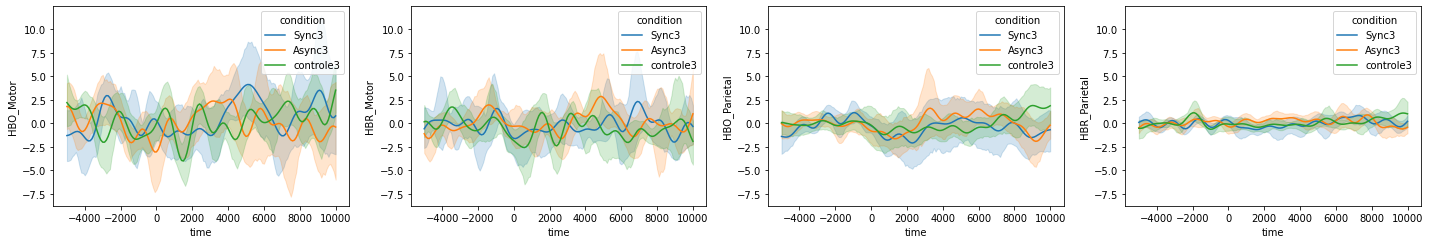

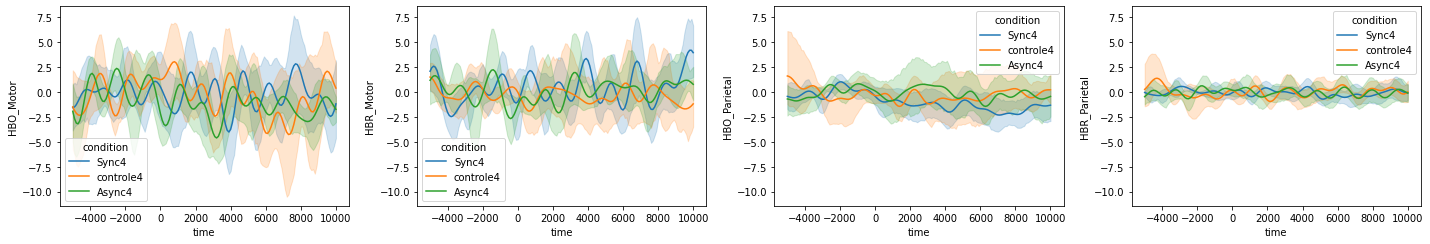

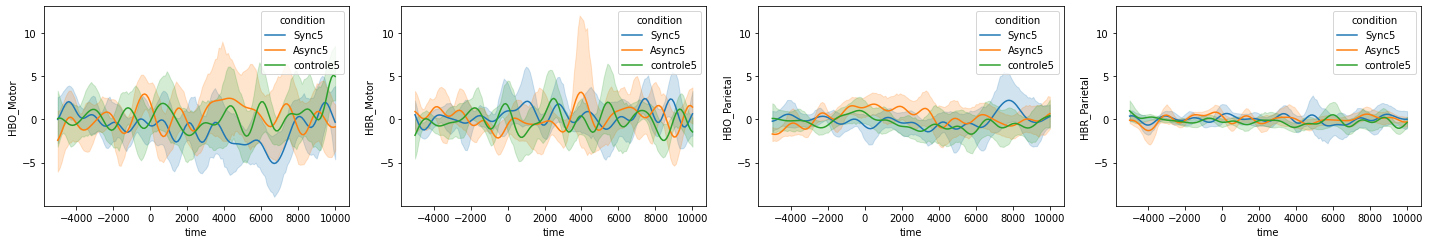

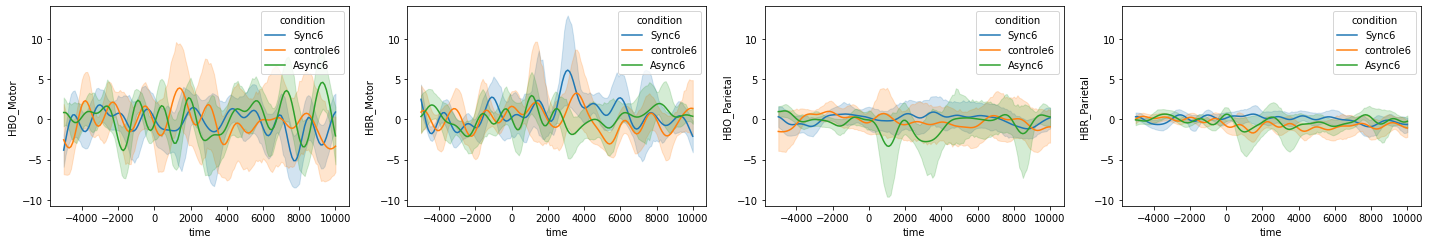

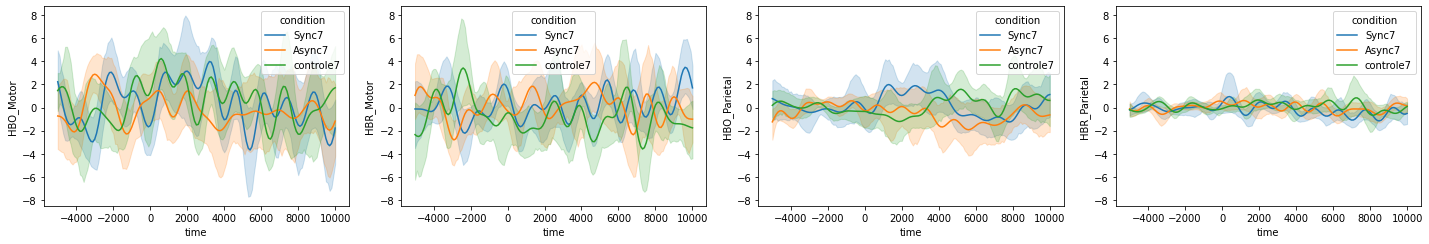

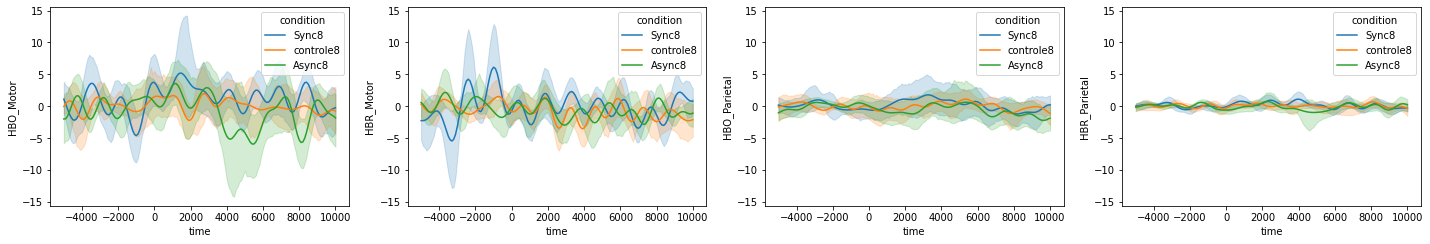

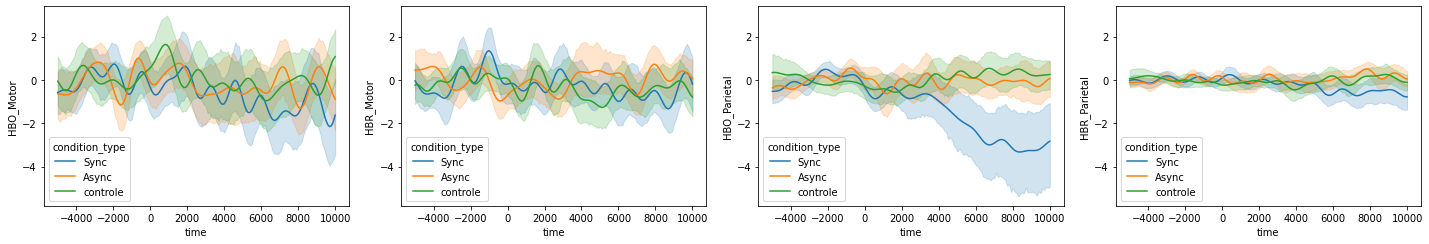

In [ ]:
for i in range(1,9):
  fig = plt.figure(figsize=(20,3.5))
  ax1 = plt.subplot(1,4,1)
  sns.lineplot(x='time', y='HBO_Motor', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,2, sharey = ax1 )
  sns.lineplot(x='time', y='HBR_Motor', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,3, sharey = ax1 )
  sns.lineplot(x='time', y='HBO_Parietal', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])
  plt.subplot(1,4,4, sharey = ax1 )
  sns.lineplot(x='time', y='HBR_Parietal', hue='condition', data=df_epochs_mean[ df_epochs_mean['condition_phase'] == str(i) ])

  plt.tight_layout()
  plt.show()

fig = plt.figure(figsize=(20,3.5))
ax1 = plt.subplot(1,4,1)
sns.lineplot(x='time', y='HBO_Motor', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,2, sharey = ax1 )
sns.lineplot(x='time', y='HBR_Motor', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,3, sharey = ax1 )
sns.lineplot(x='time', y='HBO_Parietal', hue='condition_type', data=df_epochs_mean )
plt.subplot(1,4,4, sharey = ax1 )
sns.lineplot(x='time', y='HBR_Parietal', hue='condition_type', data=df_epochs_mean )

plt.tight_layout()
plt.show()